# Running times of gradient descent, online and minibatch SGD

I've argued in the notes that online SGD and minibatch SGD should have faster running times than batch GD. Let's check that. 

In [1]:
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
from matplotlib import ticker, cm
import math
import random
from sklearn.utils import shuffle
import time

This is the standard gradient descent algorithm, modified so that it keeps track of the running time. By implementing different grad(x) methods we're going to use it for gradient descent, for SGD and for minibatch SGD.

In [2]:
def time_gradient_descent(grad,x0,eta,steps=10):
    path=[x0]
    times=[time.time()]
    x=x0
    for i in range(steps):
        x=x-eta*grad(x)
        path.append(x)
        times.append(time.time())
    return np.array(path),np.array(times)-times[0]

## A random dataset for logistic regression

We generate a random dataset and apply logistic regression.

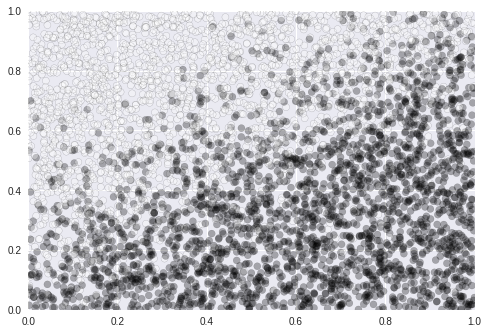

In [3]:
def logistic(z):
    return 1/(1+math.e**(-z))

def det_class(x):
    a,b=0.7,0.2
    d=a*x[0]+b-x[1]
    if random.random()<logistic(8*d):
        return 1
    return -1

def gen_samples(N):
    X=[(random.random(),random.random()) for i in range(N)]
    y=np.array([det_class(x) for x in X])
    X=np.array(X)
    return X,y

# generate data set, upper left -> class -1, lower right -> class 1

X,y=gen_samples(5000)
fig, ax = plt.subplots()
ax.scatter(X[:,0],X[:,1],c=y,alpha=0.3,edgecolor='k')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Next, we implement the logistic loss function as well as the gradient of logistic loss. Recall that logistic loss is defined as
$$
L(w)=\frac{1}{|S|}\sum_{(x,y)\in S}-\log\left(\frac{1}{1+e^{-y(w^Tx+b)}}\right)
$$
Note that we perform logistic regression with a bias term $b$.

We also implement the different gradient methods for batch GD, online SGD, and minibatch SGD.

In [4]:
def aff_fun(W,x):
    """returns sum W_ix_i+b, where b is the last entry of W"""
    return sum(W[:-1]*x)+W[-1]

# given data set, return logistic loss by weight vector
def log_reg_factory(X,y):
    def log_reg_loss(W):
        return 1/len(X)*sum([-math.log(logistic(y[i]*aff_fun(W,X[i,:])),2) for i in range(len(X))])
    return log_reg_loss

# given data set, return gradient of logistic loss 
def log_reg_grad_factory(X,y):
    def log_reg_grad(W):
        g0=sum([ -y[i]*X[i,0]*logistic(-y[i]*aff_fun(W,X[i,:])) for i in range(len(X)) ])
        g1=sum([ -y[i]*X[i,1]*logistic(-y[i]*aff_fun(W,X[i,:])) for i in range(len(X)) ])        
        g2=sum([ -y[i]*logistic(-y[i]*aff_fun(W,X[i,:])) for i in range(len(X)) ])
        return np.array([g0,g1,g2])/len(X)/math.log(2) 
    return log_reg_grad

def stoch_grad_factory(X,y):
    # permute randomly
    X, y = sklearn.utils.shuffle(X,y)
    class Online:
        def __init__(self):
            self.i=0
    
        def subgrad(self,W):
            g0= -y[self.i]*X[self.i,0]*logistic(-y[self.i]*aff_fun(W,X[self.i,:]))
            g1= -y[self.i]*X[self.i,1]*logistic(-y[self.i]*aff_fun(W,X[self.i,:]))         
            g2= -y[self.i]*logistic(-y[self.i]*aff_fun(W,X[self.i,:]))
            self.i=(self.i+1)%len(y)
            return np.array([g0,g1,g2])/math.log(2) 
    return Online().subgrad

def minibatch_grad_factory(X,y,size=10):
    X, y = sklearn.utils.shuffle(X,y)
    class Minibatcher:
        def __init__(self):
            self.minibatch=0
            
        def subgrad(self,W):
            start=self.minibatch*size
            end=min(len(y),(self.minibatch+1)*size)
            g0=sum([ -y[i]*X[i,0]*logistic(-y[i]*aff_fun(W,X[i,:])) for i in range(start,end) ])
            g1=sum([ -y[i]*X[i,1]*logistic(-y[i]*aff_fun(W,X[i,:])) for i in range(start,end) ])        
            g2=sum([ -y[i]*logistic(-y[i]*aff_fun(W,X[i,:])) for i in range(start,end) ])
            if end==len(y):
                self.minibatch=0
            else:
                self.minibatch+=1
            return np.array([g0,g1,g2])/size/math.log(2) 
    return Minibatcher().subgrad

loss=log_reg_factory(X,y)

## The running times

In [5]:
## the initial classification line
W0=[0,-1,0.1]

Let's pick the learning rates we determined in an earlier notebook. Notably that's $\eta=6$ for gradient descent, $\eta=0.1$ for online SGD and $\eta=1$ for minibatch SGD.

In [6]:
eta_GD=6
eta_online=0.1
eta_minibatch=1

In [7]:
print("batch GD")
start=time.time()
path_GD,times_GD=time_gradient_descent(log_reg_grad_factory(X,y),W0,eta_GD,steps=20)
end=time.time()
print("--> {:.2}s".format(end-start))
print("minibatch SGD")
start=time.time()
path_mini,times_mini=time_gradient_descent(minibatch_grad_factory(X,y,size=20),W0,eta_minibatch,steps=400)
end=time.time()
print("--> {:.2}s".format(end-start))
print("online SGD")
start=time.time()
path_online,times_online=time_gradient_descent(stoch_grad_factory(X,y),W0,eta_online,steps=10000)
end=time.time()
print("--> {:.2}s".format(end-start))

batch GD
--> 1.8s
minibatch SGD
--> 0.14s
online SGD
--> 0.22s


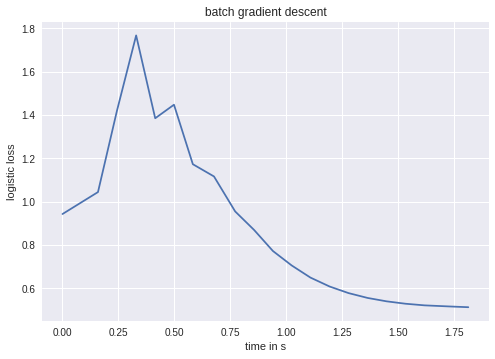

In [8]:
_,ax=plt.subplots()
ax.plot(times_GD,[loss(p) for p in path_GD])
ax.set_xlabel('time in s')
ax.set_ylabel('logistic loss')
ax.set_title('batch gradient descent')
plt.savefig('gd_time.png',dpi=300)

Text(0.5, 1.0, 'minibatch gradient descent, minibatch size=20')

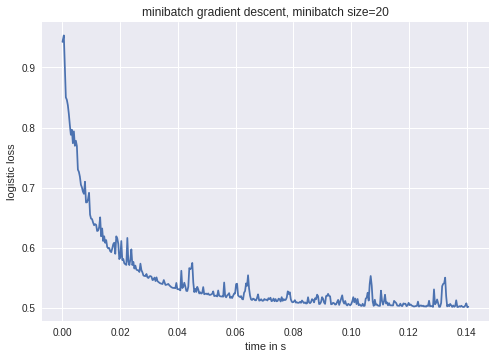

In [9]:
losses_mini=[loss(p) for p in path_mini]
_,ax=plt.subplots()
ax.plot(times_mini,losses_mini)
ax.set_xlabel('time in s')
ax.set_ylabel('logistic loss')
ax.set_title('minibatch gradient descent, minibatch size=20')

Text(0.5, 1.0, 'online gradient descent')

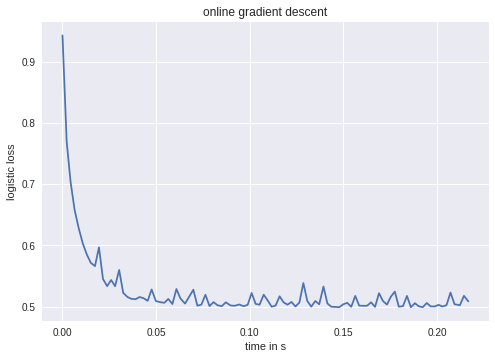

In [10]:
## plotting all datapoints is costly as we need to evaluate the loss 10000 times
## so let's only plot every 100th iteration
slc=range(0,len(path_online),100)
losses_online=[loss(p) for p in path_online[slc]]
_,ax=plt.subplots()
ax.plot(times_online[slc],losses_online)
ax.set_xlabel('time in s')
ax.set_ylabel('logistic loss')
ax.set_title('online gradient descent')

Batch gradient descent needs about 4s to reach a loss of 0.6, while both online SGD and minibatch SGD manage to do so in about 0.1s. 

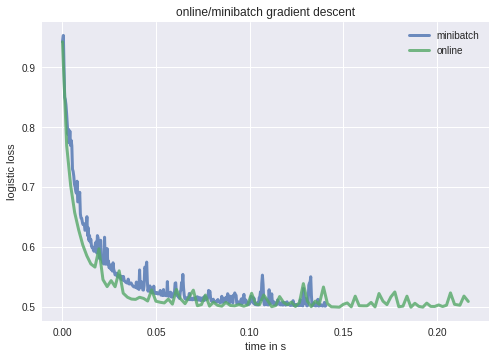

In [13]:
_,ax=plt.subplots()
ax.plot(times_mini,losses_mini,label='minibatch',alpha=0.8,linewidth=3)
ax.plot(times_online[slc],losses_online,label='online',alpha=0.8,linewidth=3)
ax.set_xlabel('time in s')
ax.set_ylabel('logistic loss')
ax.legend()
ax.set_title('online/minibatch gradient descent')
plt.savefig('sgd_time.png',dpi=300)

Online and minibatch SGD seem to perform equally well. Perhaps a larger or smaller minibatch size would make a difference.